# File Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,RandomForestRegressor,RandomForestClassifier,VotingRegressor

# Load data

In [3]:
df_processed_data = pd.read_csv('shannon_data_residential.csv')

# Additional Preprocessing

In [4]:
# Split categorical and numeric variables
numeric_vars = [x for x in list(df_processed_data) if type(df_processed_data.loc[0,x])!=type('str')]
categorical_vars = [x for x in list(df_processed_data) if type(df_processed_data.loc[0,x])==type('str')]

# convert categorical variables to one-hot-encoded variables (binary)
df_one_hot_encoded = pd.get_dummies(df_processed_data[categorical_vars])

# get just numeric variables
df_numeric = df_processed_data[numeric_vars]
df_numeric = df_numeric.astype(float)

# Add back the one-hot-encoded categorical variables
df_numeric = df_numeric.join(df_one_hot_encoded)

# First, remove columns which have a significant portion of NAs (we're saying more than 1000
na_count = df_numeric.isna().sum().sort_values(ascending=True)
df_numeric = df_numeric[[x for x in list(df_numeric) if x not in list(na_count[na_count>1000].index)]]
# Now for all the remaining nans, remove the rows
df_numeric = df_numeric.dropna()

**Now drop the variables which you won't have in a predictive model** 

This makes a massive difference. If you just put in all the variables, you will get a really good model for casualties.
But the problem is that fatality and injury count are after the fact. I gather we want a predictive model.. or includes levers like arrival time 

In [5]:
df_numeric = df_numeric[[x for x in list(df_numeric) if x not in ['Injury_Count.x','Fatality_Count.x']]]

In [6]:
# also need to drop variables which are always zero
df_numeric = df_numeric[[x for x in list(df_numeric) if x not in ['GNS_Use_Category_Appurtenant','GNS_Use_Category_Forestry, Mining','GNS_Roof_Const_Roughcast,etc']]]

In [7]:
target_variable = 'Casualty_Count.x'
independent_variables = [x for x in list(df_numeric) if x!=target_variable]

# split into testing and training
df_training = df_numeric.sample(int(len(df_numeric)*0.8))
df_testing = df_numeric[~df_numeric.index.isin(df_training.index)]

# Normalise the data
training_mins = np.min(df_training[independent_variables])
training_maxes = np.max(df_training[independent_variables])

df_training.loc[:,independent_variables] = (df_training[independent_variables]-training_mins)/(training_maxes-training_mins)
df_testing.loc[:,independent_variables] = (df_testing[independent_variables]-training_mins)/(training_maxes-training_mins)

# Adding extra rows which have casualties so that the dataset is approximately equal
df_training_0 = df_training[df_training[target_variable]==0]
df_training_gt0 = df_training[df_training[target_variable]>0]
df_training = df_training_0.append(pd.concat([df_training_gt0]*int(1+len(df_training_0)/len(df_training_gt0))))


C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [8]:
# Just to make it faster
df_training = df_training.sample(50000)

# Model Training and predictions

In [9]:
# Train the model
rf = RandomForestRegressor()
rf.fit(df_training[independent_variables],df_training[target_variable])

RandomForestRegressor()

In [10]:
predictions = rf.predict(df_testing[independent_variables])

In [11]:
df_testing.loc[:,'Casualty_Count.x_predicted'] = predictions
df_testing.loc[:,'error'] = df_testing['Casualty_Count.x']-df_testing['Casualty_Count.x_predicted']

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# Results Analysis

Text(0.5, 1.0, 'histogram of actual casualties (blue) and casualties predicted (orange)')

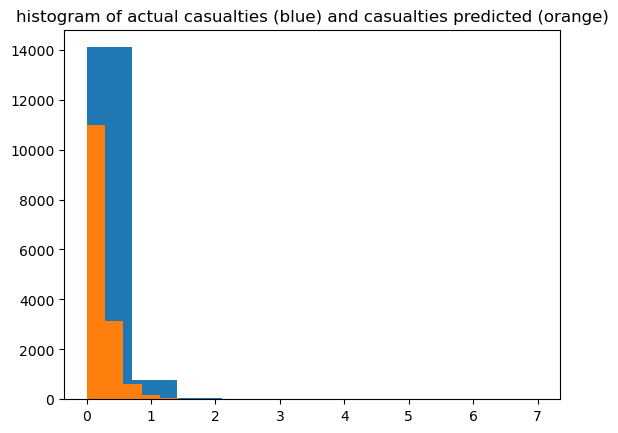

In [12]:
plt.hist(df_testing['Casualty_Count.x'])
plt.hist(df_testing['Casualty_Count.x_predicted'])
plt.title('histogram of actual casualties (blue) and casualties predicted (orange)')

Text(0.5, 1.0, 'histogram of the difference between actual casualties and casualties predicted')

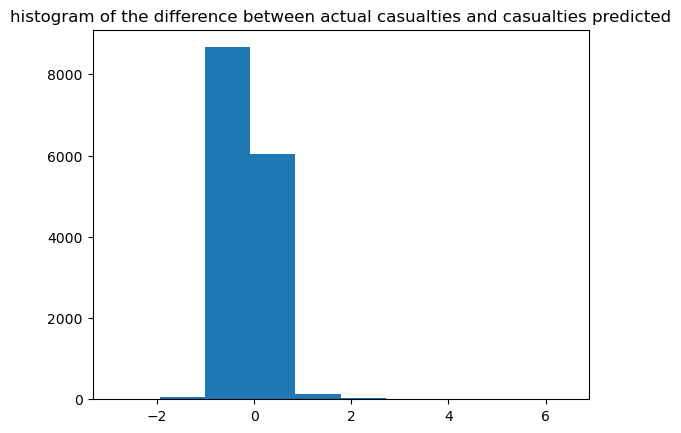

In [13]:
plt.hist(df_testing['error'])
plt.title('histogram of the difference between actual casualties and casualties predicted')

In [14]:
np.max(df_testing.error)

6.42

In [15]:
np.min(df_testing.error)

-2.86

In [16]:
np.mean(df_testing.error**2)

0.12498941735233286

In [17]:
np.median(df_testing.error**2)

0.019600000000000003

In [18]:
df_testing.loc[:,'Casualty_Count.x_predicted_int'] = [int(x) for x in df_testing['Casualty_Count.x_predicted']]
df_testing.loc[:,'error_int'] = df_testing['Casualty_Count.x']-[int(x) for x in df_testing['Casualty_Count.x_predicted_int']]


In [19]:
actual_vs_predicted_casuality_dict = {}
for casualty_count,group in df_testing.groupby('Casualty_Count.x'):
    actual_vs_predicted_casuality_dict.update({
        casualty_count:{k:len(v) for k,v in group.groupby('Casualty_Count.x_predicted_int')}
    })
    

In [20]:
group['Casualty_Count.x_predicted_int']

49177    0
Name: Casualty_Count.x_predicted_int, dtype: int64

In [21]:
df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
df_result_summary

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


,0,1,2
0.0,14027,64.0,9.0
1.0,695,67.0,1.0
2.0,53,1.0,0.0
3.0,19,0.0,0.0
4.0,9,0.0,0.0
5.0,2,0.0,0.0
6.0,1,0.0,0.0
7.0,1,0.0,0.0


In [22]:
df_feature_importance = pd.DataFrame.from_dict({x:y for x,y in zip(list(independent_variables),rf.feature_importances_)},orient='index')
df_feature_importance.rename(columns={0:'importance'},inplace=True)
df_feature_importance.sort_values('importance',ascending=False,inplace=True)
df_feature_importance

,importance
Second_Arrival_Mins.x,0.155749
Damage_m2.x,0.042080
Fire_Cause_Group_Name_Carelessness with Heat Source,0.025568
OID_,0.019551
GNS_Neighb_Dist.x,0.014821
...,...
GNS_Wall_Const_Glass,0.000001
GNS_Roof_Const_Weatherboard,0.000000
GNS_Roof_Const_Brick,0.000000
GNS_Roof_Const_Glass,0.000000


# Classifier

In [23]:
df_testing.loc[:,target_variable] = [0 if x<1 else 1 for x in df_testing[target_variable]]
df_training.loc[:,target_variable] = [0 if x<1 else 1 for x in df_training[target_variable]]

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [24]:
# Train the model
rf = GradientBoostingClassifier()
rf.fit(df_training[independent_variables],df_training[target_variable])

GradientBoostingClassifier()

In [25]:
predictions = rf.predict(df_testing[independent_variables])

In [26]:
df_testing.loc[:,'Casualty_Count.x_predicted'] = predictions
df_testing.loc[:,'error'] = df_testing['Casualty_Count.x']-df_testing['Casualty_Count.x_predicted']

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [27]:
df_testing.loc[:,'Casualty_Count.x_predicted_int'] = [int(x) for x in df_testing['Casualty_Count.x_predicted']]
df_testing.loc[:,'error_int'] = df_testing['Casualty_Count.x']-[int(x) for x in df_testing['Casualty_Count.x_predicted_int']]


In [28]:
actual_vs_predicted_casuality_dict = {}
for casualty_count,group in df_testing.groupby('Casualty_Count.x'):
    actual_vs_predicted_casuality_dict.update({
        casualty_count:{k:len(v) for k,v in group.groupby('Casualty_Count.x_predicted_int')}
    })
    

In [29]:
df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
df_result_summary

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


,0,1
0,9318,4782
1,163,686


In [30]:
tp = df_result_summary.loc[1,1]
tn = df_result_summary.loc[0,0]
fn = df_result_summary.loc[1,0]
fp = df_result_summary.loc[0,1]

In [31]:
fscore = 2*tp/(2*tp+fp+fn)
fscore

0.21719170492322304